In [1]:
#imports
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
splat.initializeStandards()
import seaborn as sns
splat.initializeStandards(all=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%matplotlib inline


Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database








In [2]:
def get_colors(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = splat.filterMag(sp, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

In [3]:
#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.3) | (splat_db.J_2MASS_E > 0.3)  |
                (splat_db.SPEX_TYPE.apply(splat.typeToNum) <15))]

sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [4]:
#get y dwarfs
def get_shortname(n):
    return splat.designationToShortName(n).replace('J', 'WISE')
schn='/Users/caganze/research/wisps/data/schneider/*.txt'
schntb=pd.read_csv('/Users/caganze/research/wisps/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [5]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

In [6]:
#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

In [7]:
def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df

In [42]:
#tdwarfs.MEDIAN_SNR

207     227.000000
1912    214.000000
2007    159.000000
1717    155.000000
1854    135.000000
962     118.000000
679     113.000000
725     100.000000
2075     97.931709
808      96.000000
Name: MEDIAN_SNR, dtype: float64

In [9]:
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [10]:
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [11]:
#smlf

In [12]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: splat.getSpectrum(filename=x)[0])
sds_spectra=sds.DATA_FILE.apply(lambda x: splat.getSpectrum(filename=x)[0])

In [13]:
schntb['spectra']=[x[0] for x in  spectra_schn]

schntb['snr']=[x[1] for x in  spectra_schn]

schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

all_spectra=np.concatenate([templs,schntb.spectra.values ])

In [17]:
#import pickle
#output = open('/users/caganze/research/popsims/data/splat_spectra.pkl', 'wb')
#pickle.dump(all_spectra, output)
#output.close()

#import pickle
#output = open('/users/caganze/research/popsims/data/sd_spectra.pkl', 'wb')
#pickle.dump(sds_spectra, output)
#output.close()

In [18]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [19]:
spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
                     schntb.Spec.apply(make_spt_number).values,
                    ])

In [20]:
assert len(spts) == len(all_spectra)

In [21]:
sds_spts=sds.SPEX_TYPE.apply(make_spt_number).values

In [22]:
fl_pairs= [['WFIRST_WFIJ', '2MASS J'],
               ['WFIRST_WFIY', '2MASS J'],
               ['WFIRST_WFIZ', '2MASS J'],
               ['WFIRST_WFIH', '2MASS H'],
               ['WFIRST_WFIF', '2MASS H'],
               ['EUCLID_J', '2MASS J'],
               ['EUCLID_H', '2MASS H'],
               ['EUCLID_Y','2MASS J'],
               ['WFC3_F110W', '2MASS J']]

In [23]:
def wfirst_colors(sp):
    sp.normalize()
    res={}
    for p in fl_pairs:
        res.update({p[0]+'and'+p[1]: \
                    get_colors(sp, p[0], p[1])})
    return res

In [24]:
df=pd.DataFrame.from_records([wfirst_colors(x) for x in tqdm(all_spectra)])

100%|██████████| 336/336 [07:52<00:00,  1.41s/it]


In [25]:
sd_df=pd.DataFrame.from_records([wfirst_colors(x) for x in tqdm(sds_spectra)])
sd_df['spt']=sds_spts

100%|██████████| 38/38 [00:57<00:00,  1.51s/it]


In [26]:
df['spt']=spts

In [27]:

def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    #use median sigma
    #median_sigma= np.nanmedian(sigma_y)
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [28]:
#

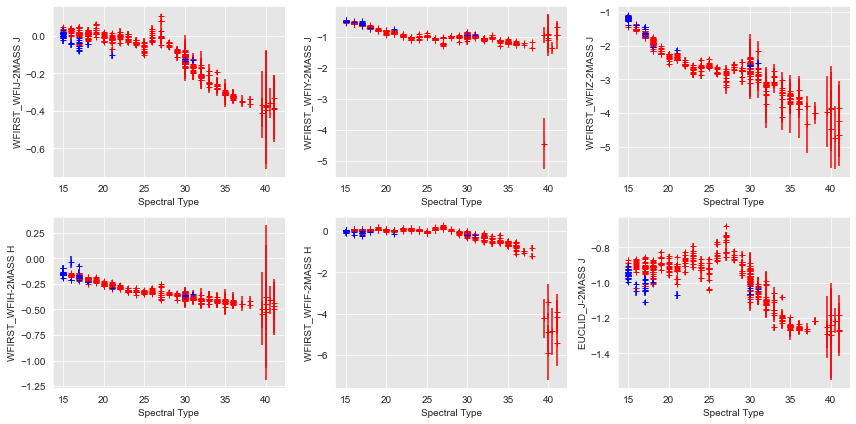

In [29]:
fig, ax=plt.subplots(2, 3, figsize=(12, 6))
for c, a in zip(df.columns, np.concatenate(ax)):
    if c=='spt':
        pass
    else:
        #fit=None
        vals=np.vstack(df[c].apply(lambda x: np.array(x)).values)
        sd_vals=np.vstack(sd_df[c].apply(lambda x: np.array(x)).values)
        #mask= np.logical_or.reduce([np.isnan(spts), 
        #                            np.isnan(vals[:,0]),
        #                            np.isnan(vals[:,1]),
        #                           abs(vals[:,1]/vals[:,0]) > 100.])
        
        #m, fit= fit_with_nsigma_clipping(spts[~mask], 
        #                              vals[:,0][~mask], 
        #                              vals[:,1][~mask], 6, sigma=5.)
        
       
      
        a.errorbar(spts, vals[:,0], fmt='+', 
                   yerr=vals[:,1], color='r')
        
        a.errorbar(sds_spts, sd_vals[:,0], fmt='+', 
                   yerr=sd_vals[:,1], color='b')
       
        
        #a.plot(np.arange(15, 43), fit(np.arange(15, 43)), c='k')
        a.set_ylabel(c.upper().replace('AND', '-'))
        a.set_xlabel('Spectral Type')
        plt.tight_layout()


In [30]:
#absolute magnitude relation
import splat.empirical as spe

kirkpa2019pol={'2MASS H':{'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                    'scatter':.67, 'range':[36, 44]}}
kirkpa2020pol={'2MASS H':{'pol':np.poly1d(np.flip([-6.918e01, 1.1863e+01,-5.4084e-1, 8.466e-03 ])), 
                    'scatter':.51, 'range':[36, 44]}}
best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]}}

BEST={}
for k in best_dict.keys():
    BEST[k]=fit_with_nsigma_clipping(np.array(best_dict[k]['spt']), 
                                      np.array(best_dict[k]['values']), 
                                      np.array(best_dict[k]['rms'])
                                     , 6, sigma=5.)
from astropy.io import ascii
def make_mamajek_fit(spt):
    mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(splat.typeToNum).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return ((jval, 0.4), (hval, 0.4))

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        pol=kirkpa2019pol[filt]['pol']
        unc=kirkpa2019pol[filt]['scatter']
        return pol(spt-30), unc
    

def get_abs_mag(spt, flter):
    m, munc=(np.nan, np.nan)
    if flter=='2MASS J':
        #m, munc= spe.typeToMag(spt, '2MASS J')
        ((m, munc), (h, hunc))=make_mamajek_fit(spt)
        
    if flter=='2MASS H':
        if spt <36:
            #m=BEST['2MASS H'][1](spt)
            #munc= np.nanmedian(best_dict[k]['rms'])
            #m, munc=spe.typeToMag(spt, '2MASS H')
            ((j, junc), (m, munc))=make_mamajek_fit(spt)
        else:
            m, munc=absolute_mag_kirkpatrick(spt, '2MASS H')
            
    return m, munc

In [31]:
#plt.plot(absolute_mag_kirkpatrick(np.arange(35, 45), '2MASS H')[0])

In [32]:
#GHJK

In [33]:
def get_abs_mags(row):
    res={}
    
    for p in fl_pairs:
        cl=p[0]+'and'+p[1]
        v, ve=get_abs_mag(row.spt, p[1])
        absm= row[cl][0]+v
        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)
        
    

In [34]:
abs_df=df.apply(get_abs_mags, axis=1)
sd_abs_df=sd_df.apply(get_abs_mags, axis=1)

In [35]:
FITS={}

In [36]:
#gh

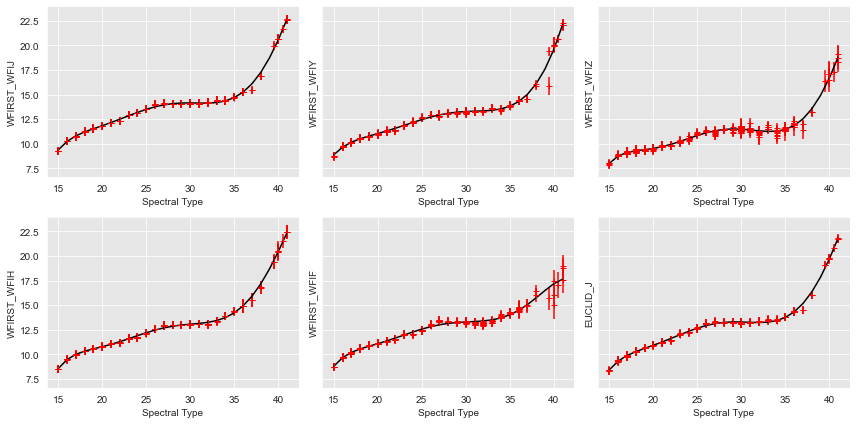

In [37]:
fig, ax=plt.subplots(2, 3, figsize=(12, 6), sharey=True)

for c, a in zip(abs_df.columns, np.concatenate(ax)):
    if c=='spt':
        pass
    else:
        vals=np.vstack(abs_df[c].values)
        spts=df.spt.values
        #print (vals[:,1])
        mask= np.logical_or.reduce([np.isnan(spts), 
                                    np.isnan(vals[:,0]),
                                    np.isnan(vals[:,1])])

        m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                      vals[:,0][~mask], 
                                      vals[:,1][~mask], 6, sigma=3.)
        
        
        a.errorbar(spts, vals[:,0], fmt='+', 
                   yerr=vals[:,1], color='r')
          
        a.errorbar(spts[~mask][~m], vals[:,0][~mask][~m], fmt='+', 
                   yerr=vals[:,1][~mask][~m], color='b')
        FITS.update({c: (fit, np.nanmedian(vals[:,1]))})
        a.plot(np.arange(15, 42), fit(np.arange(15, 42)), c='k')
        a.set_ylabel(c)
        a.set_xlabel('Spectral Type')
        plt.tight_layout()
        #a.set_xlim([15, 41])
        #a.set_ylim([8, 25])


In [38]:
import pickle
output = open('/users/caganze/research/popsims/data/polynomial_relations.pkl', 'wb')
pickle.dump(FITS, output)
output.close()